<a href="https://colab.research.google.com/github/dokunoale/chagas/blob/dev/notebooks/CNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hybrid Convolutional and Bidirectional GRU model for ECG binary classification


## Dataset and dependencies loading

In [ ]:
!git clone https://github.com/dokunoale/chagas.git
!pip install -q -r chagas/requirements.txt


# Download the dataset
import gdown
url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/

Cloning into 'chagas'...
remote: Enumerating objects: 673, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 673 (delta 57), reused 46 (delta 46), pack-reused 565 (from 2)
Receiving objects: 100% (673/673), 10.18 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (331/331), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 24.8 MB/s eta 0:00:00


Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=b9e27f7e-0cb2-44ee-ab01-4832f0427c02
To: /content/dataset.zip
100%|██████████| 623M/623M [00:03<00:00, 197MB/s]


In [ ]:
import sys
sys.path.append("/content/chagas/src")


import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

This code sets up the validation and test datasets for a Chagas disease classification task using ECG recordings. It begins by defining a custom noise reduction filter (`FiltfiltNoiseReducer`) with parameters tailored for ECG signals sampled at 400 Hz. Then, using a data loader (`WfdbLoader`), it applies the filter and loads ECG recordings labeled for the presence or absence of Chagas disease from specified directories. The data is shuffled during loading to ensure randomized batches. Finally, the metadata for the test set is retrieved for further analysis or tracking.


In [ ]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer


data_path = "/content/chagas/data/big_splitted_dataset/"

# Noise reduction filter
filter = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)

# training set loading and preprocessing
train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

# validation set loading and preprocessing
validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

# test set loading and preprocessing
test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

# Array of dictionaries with more info for model analysis
y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:12<00:00, 179.16record/s]


## Training

The proposed model is based on a **hybrid Convolutional and Bidirectional GRU** architecture designed for binary classification of ECG signals with input shape (2800, 12).

- The sequence is first processed through **two 1D Convolutional layers** with increasing filter sizes (8 and 16) and kernel sizes of 5 and 3, respectively. Each convolutional layer is followed by Batch Normalization and MaxPooling to extract local temporal features, reduce dimensionality, and improve training stability.

- The extracted features are then passed to a **Bidirectional GRU layer** with 16 units, which captures both past and future temporal dependencies within the ECG sequence. A Dropout layer follows the GRU to mitigate overfitting.

- The learned temporal representations are further processed by a **Dense layer** with 8 units and ReLU activation, including additional Dropout for enhanced generalization.

- Finally, a **Dense layer** with sigmoid activation outputs the binary classification result.

In [ ]:
def build_ecg_conv_lstm_model(
    input_shape=(2800, 12),
    gru_units=16,
    dropout_rate=0.3
):
    inputs = layers.Input(shape=input_shape, name='input_layer')

    # First level Conv1D + BatchNorm + MaxPooling
    x = layers.Conv1D(filters=8, kernel_size=5, activation='relu', padding='same', name='conv1d_1')(inputs)
    x = layers.BatchNormalization(name='batch_norm_1')(x)
    x = layers.MaxPooling1D(pool_size=4, name='max_pool_1')(x)

    # Second level Conv1D + BatchNorm + MaxPooling
    x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', name='conv1d_2')(x)
    x = layers.BatchNormalization(name='batch_norm_2')(x)
    x = layers.MaxPooling1D(pool_size=4, name='max_pool_2')(x)

    # Birectional GRU
    x = layers.Bidirectional(
      layers.GRU(gru_units, return_sequences=False, name='gru'),
      name='bidirectional_gru')(x)
    x = layers.Dropout(dropout_rate, name='dropout_gru')(x)

    # Dense layers
    x = layers.Dense(8, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.5, name='dropout_dense')(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model = models.Model(inputs, outputs, name='ECG_Conv_LSTM_Model')
    return model



# Model compilation
model = build_ecg_conv_lstm_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "ECG_Conv_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2800, 8)        │           488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 2800, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_1 (MaxPooling1D)       │ (None, 700, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 700, 16)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 700, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_2 (MaxPooling1D)       │ (None, 175, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru               │ (None, 32)             │         3,264 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gru (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,521 (17.66 KB)

 Trainable params: 4,473 (17.47 KB)

 Non-trainable params: 48 (192.00 B)

In [ ]:
# Callback: early stopping and saving best model
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5138 - auc: 0.5262 - loss: 0.7233 - val_accuracy: 0.5374 - val_auc: 0.5738 - val_loss: 0.6867
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5421 - auc: 0.5568 - loss: 0.6870 - val_accuracy: 0.5936 - val_auc: 0.6366 - val_loss: 0.6713
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5627 - auc: 0.6091 - loss: 0.6748 - val_accuracy: 0.6070 - val_auc: 0.6671 - val_loss: 0.6633
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5907 - auc: 0.6462 - loss: 0.6607 - val_accuracy: 0.6471 - val_auc: 0.7081 - val_loss: 0.6278
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6549 - auc: 0.7023 - loss: 0.6367 - val_accuracy: 0.6578 - val_auc: 0.7447 - val_loss: 0.6240
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6501 - auc: 0.7126 - loss: 0.6222 - val_accuracy: 0.6515 - val_auc: 0.7506 - val_loss: 0.6225
Epoch 7/50
262/262 ━━━━━━━━━━━━━━

## Model analysis

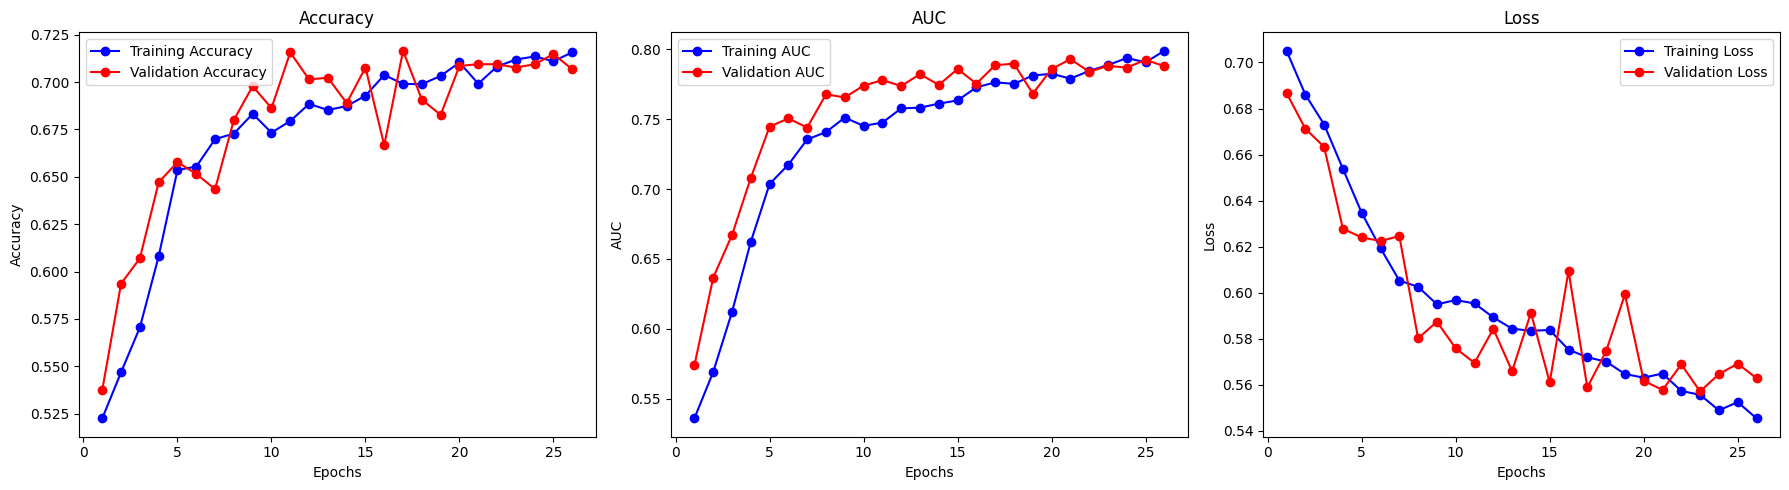

In [ ]:
from models.analysis import plot_training_metrics

# accuracy, AUC and loss plot
plot_training_metrics(history)

In [ ]:
from models.utils import find_optimal_threshold, compute_predictions
from sklearn.metrics import classification_report, accuracy_score


# Load the trained Keras model from file, specifying any custom layers used
model = tf.keras.models.load_model("best_model.keras")

# Generate predicted probabilities on the validation set
y_pred_probs = model.predict(X_val)

# Find the optimal classification threshold based on the validation set
threshold = find_optimal_threshold(y_val, y_pred_probs)

# Compute final predictions, predicted classes, and correctness flags on the test set
y_pred, y_pred_classes, correct = compute_predictions(model, X_test, y_test, threshold)

# Print a detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred_classes))

# Compute and store the overall accuracy score
accuracy = accuracy_score(y_test, y_pred_classes)
print(accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Optimal threshold: 0.459
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      1126
           1       0.70      0.71      0.71      1119

    accuracy                           0.70      2245
   macro avg       0.70      0.70      0.70      2245
weighted avg       0.70      0.70      0.70      2245

0.7042316258351893


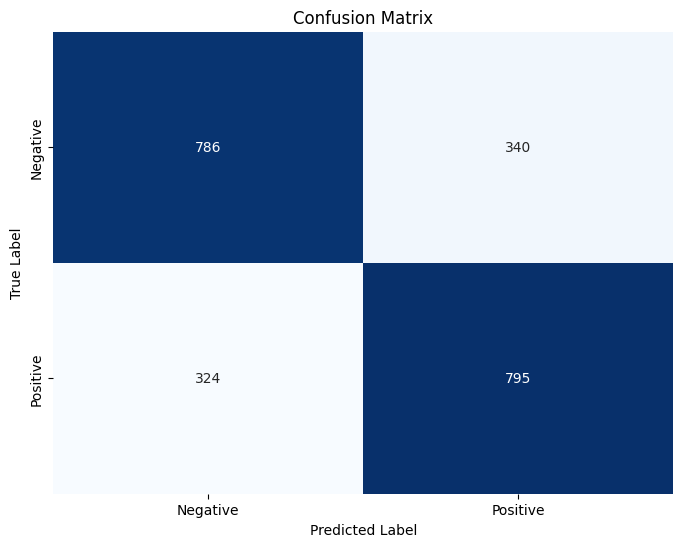

In [ ]:
from models.analysis import plot_confusion_matrix


# Confusion matrix
plot_confusion_matrix(y_test, y_pred_classes)

The next cell provides a summary of the distribution of the model's output scores.

- **Distribution of predictions**: Displays the distribution of predicted probabilities, highlighting correct (blue) and incorrect (red) classifications. A vertical dashed line indicates the 0.5 threshold, which may vary depending on the decision criterion.

- **Source distribution by model output**: Shows how the model's output scores (x-axis) are distributed across subgroups defined by data origin and label. This allows us to assess how different dataset segments are classified and to detect potential imbalances. Groups include:

    - Chagas-negative cases from CODE-15% (light teal),

    - Chagas-positive cases from CODE-15% (teal),

    - Chagas-positive cases from SaMi-Trop (yellow).

- **Age distribution for correct predictions**: Depicts the distribution of model outputs for correctly classified samples, stratified by age group. This provides insight into how prediction confidence varies across age.

- **Age distribution for incorrect predictions**: Analogous to the previous chart but focused on misclassifications. It helps identify age groups with higher error rates or ambiguous outputs.

- **Prediction success rate by age**: Summarizes the model's classification accuracy by age group, expressed as a percentage of correct predictions. Sample counts per group are reported above each bar for context.

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


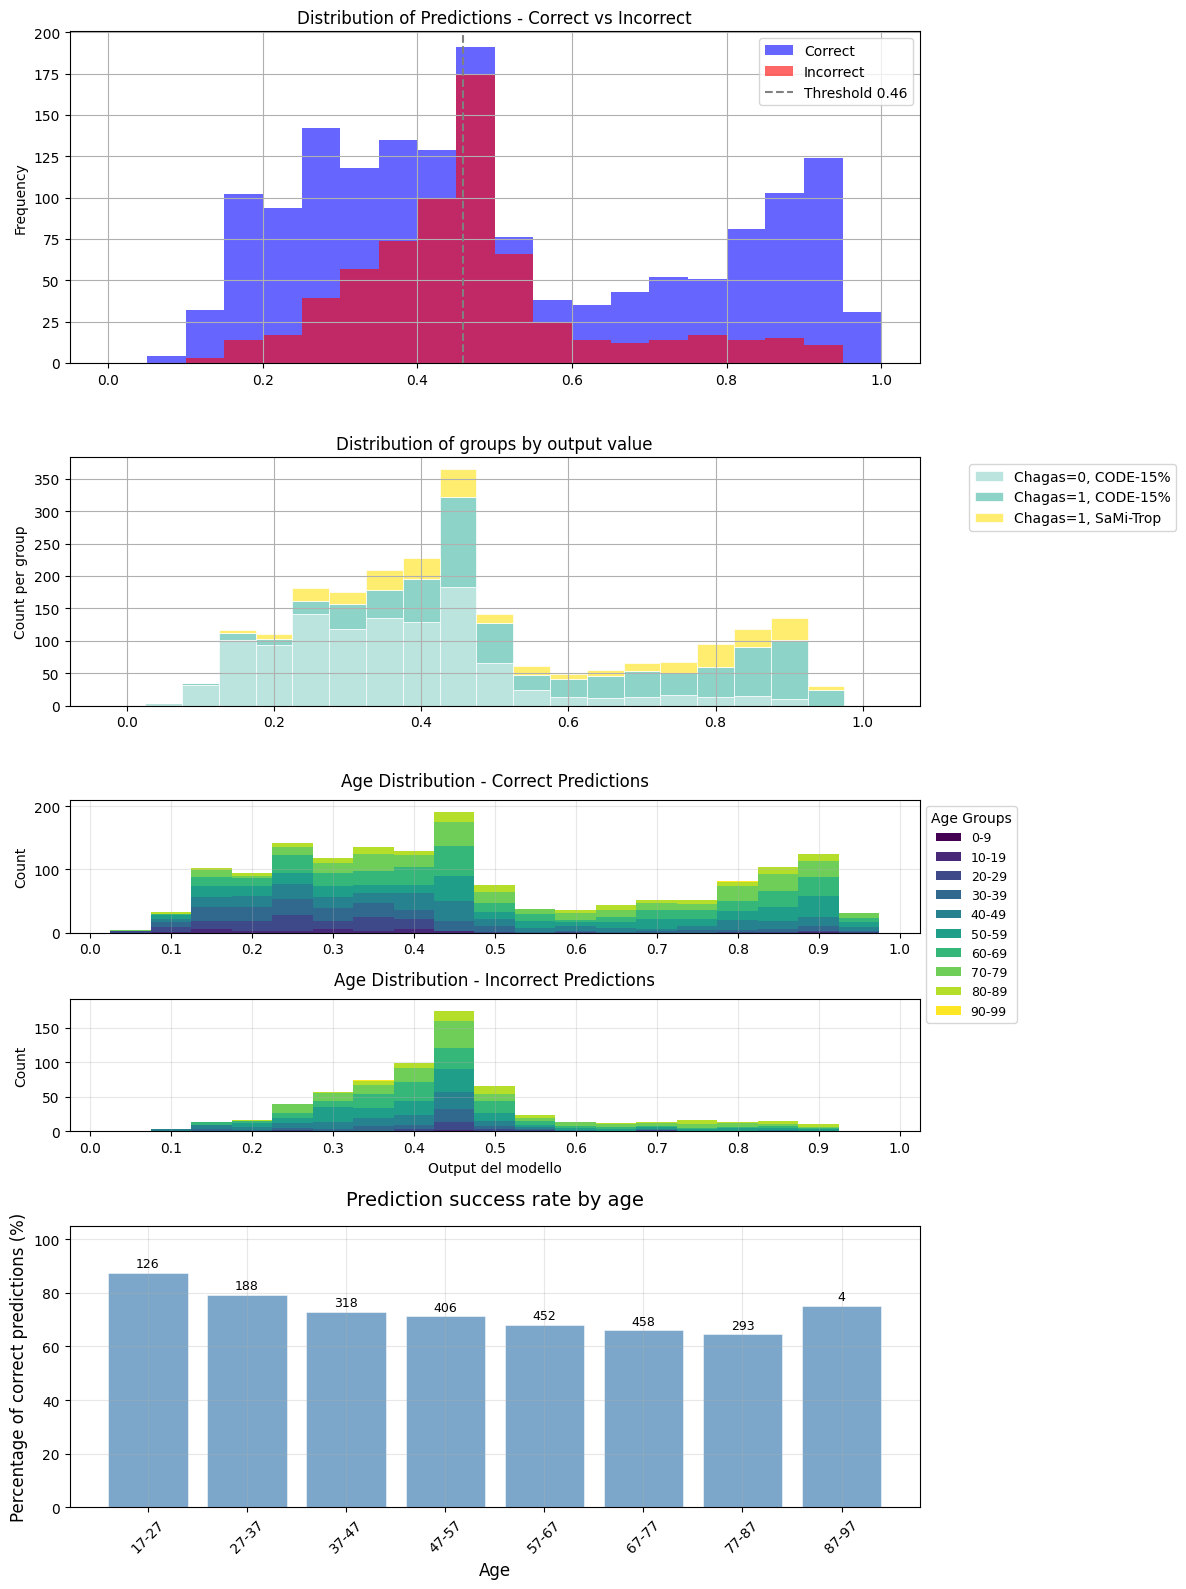

In [ ]:
from models.analysis import plot_model_analysis

plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=False)